In [1]:
import numpy as np, pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from tqdm import tqdm_notebook
from sklearn.feature_selection import VarianceThreshold
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.semi_supervised import LabelSpreading
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [3]:
oof = np.zeros(len(train)) 
pred = np.zeros(len(test))

cols = [c for c in train.columns if c not in ['id', 'target', 'wheezy-copper-turtle-magic']]

In [4]:
# STEP 3
oof = np.zeros(len(train))
preds = np.zeros(len(test))
# params = [{'reg_param': [0.1, 0.2, 0.3, 0.4, 0.5]}]
# 512 models
reg_params = np.zeros(512)
for i in tqdm_notebook(range(512)):

    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index; idx2 = test2.index
    train2.reset_index(drop=True,inplace=True)

    data = pd.concat([pd.DataFrame(train2[cols]), pd.DataFrame(test2[cols])])
    pipe = Pipeline([('vt', VarianceThreshold(threshold=2)), ('scaler', StandardScaler())])
    data2 = pipe.fit_transform(data[cols])
    train3 = data2[:train2.shape[0]]; test3 = data2[train2.shape[0]:]

    skf = StratifiedKFold(n_splits=25, random_state=42)
    for train_index, test_index in skf.split(train2, train2['target']):

        clf = QuadraticDiscriminantAnalysis(0.5)
#         clf = GridSearchCV(qda, params, cv=4)
        clf.fit(train3[train_index,:],train2.loc[train_index]['target'])
#         reg_params[i] = clf.best_params_['reg_param']
        oof[idx1[test_index]] = clf.predict_proba(train3[test_index,:])[:,1]
        preds[idx2] += clf.predict_proba(test3)[:,1] / skf.n_splits

auc = roc_auc_score(train['target'], oof)
print(f'AUC: {auc:.5}')


AUC: 0.96571


In [5]:
# STEP 4
train_f = train.copy()
train_f.loc[oof > 0.995, 'target'] = 1
train_f.loc[oof < 0.005, 'target'] = 0
oof_ls = np.zeros(len(train))
pred_te_ls = np.zeros(len(test))
for k in tqdm_notebook(range(512)):
    train2 = train_f[train_f['wheezy-copper-turtle-magic']==k] 
    train2p = train2.copy(); idx1 = train2.index 
    test2 = test[test['wheezy-copper-turtle-magic']==k]
    test2['target']=-1
    train2p = pd.concat([train2,test2],axis=0)
    train2p.reset_index(drop=True,inplace=True)
    sel = VarianceThreshold(threshold=1.5).fit(train2p[cols])     
    train4p = sel.transform(train2p[cols])
    train4 = sel.transform(train2[cols])
    test4 = sel.transform(test2[cols])
    
    skf = StratifiedKFold(n_splits=25, random_state=42, shuffle=True)
    for train_index, test_index in skf.split(train4p, train2p['target']):
        test_index3 = test_index[ test_index<len(train4)]
        clf = LabelSpreading(gamma=0.01,kernel='rbf', max_iter=10,n_jobs=-1)
        clf.fit(train4p[train_index,:],train2p.loc[train_index]['target'])
        oof_ls[idx1[test_index3]] = clf.predict_proba(train4[test_index3,:])[:,1]
        pred_te_ls[test2.index] += clf.predict_proba(test4)[:,1] / skf.n_splits
auc = roc_auc_score(train['target'],oof_ls)
print('CV for LabelSpreading =',round(auc,5))


CV for LabelSpreading = 0.94322


In [6]:
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture

# INITIALIZE VARIABLES
cols = [c for c in train.columns if c not in ['id', 'target']]
cols.remove('wheezy-copper-turtle-magic')
oof3 = np.zeros(len(train))
preds = np.zeros(len(test))

# BUILD 512 SEPARATE MODELS
for i in tqdm_notebook(range(512)):
    # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index; idx2 = test2.index
    train2.reset_index(drop=True,inplace=True)
    train2p = train2.copy()
    
    # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
#     sel = VarianceThreshold(threshold=1.5).fit(train2[cols])
#     train3 = sel.transform(train2[cols])
#     test3 = sel.transform(test2[cols])
    data = pd.concat([pd.DataFrame(train2[cols]), pd.DataFrame(test2[cols])]) 
    pipe = Pipeline([('vt', VarianceThreshold(threshold=2)), ('scaler', StandardScaler())])
    data2 = pipe.fit_transform(data[cols])
    train3 = data2[:train2.shape[0]]
    test3 = data2[train2.shape[0]:]
    train4 = np.hstack([train3,np.array([oof_ls[idx1]]).T])
    test4 = np.hstack([test3,np.array([pred_te_ls[idx2]]).T])    
    n_components = 3
    feat_num = train4.shape[1]+10
    gmm = BayesianGaussianMixture(n_components=n_components, verbose=False, max_iter=1000, random_state=42)
    gmm.fit(train3[train2['target']== 0])
    # gmm.fit(train3)
    clusters0 = gmm.predict(train3[train2['target']== 0])
#     print("clusters:", clusters0)
    train2p.loc[train2['target']== 0,'target'] = clusters0
    gmm = BayesianGaussianMixture(n_components=n_components, verbose=False, max_iter=1000, random_state=42)
    gmm.fit(train3[train2['target']== 1])
    # gmm.fit(train3)
    clusters1 = gmm.predict(train3[train2['target']== 1])
    train2p.loc[train2['target']== 1,'target'] = clusters1 + 3
#     print("clusters:", clusters1+3)
    
    if(sum(train2p['target']==0)<feat_num or\
       sum(train2p['target']==1)<feat_num or\
       sum(train2p['target']==2)<feat_num or\
       sum(train2p['target']==3)<feat_num or\
       sum(train2p['target']==4)<feat_num or\
       sum(train2p['target']==5)<feat_num):
        
        n_components = 2
        gmm = BayesianGaussianMixture(n_components=n_components, verbose=False, max_iter=1000, random_state=42)
        gmm.fit(train3[train2['target']== 0])
        # gmm.fit(train3)
        clusters0 = gmm.predict(train3[train2['target']== 0])
    #     print("clusters:", clusters0)
        train2p.loc[train2['target']== 0,'target'] = clusters0
        gmm = BayesianGaussianMixture(n_components=n_components, verbose=False, max_iter=1000, random_state=42)
        gmm.fit(train3[train2['target']== 1])
        # gmm.fit(train3)
        clusters1 = gmm.predict(train3[train2['target']== 1])
        train2p.loc[train2['target']== 1,'target'] = clusters1 + 2
        if(sum(train2p['target']==0)<feat_num or\
           sum(train2p['target']==1)<feat_num or\
           sum(train2p['target']==2)<feat_num or\
           sum(train2p['target']==3)<feat_num):

            n_components = 1
            train2p = train2.copy()

    
    
    oofd = np.zeros(len(train2))
    oofd2 = np.zeros(len(train2))
    oofd3 = np.zeros(len(train2))
    # STRATIFIED K-FOLD
    skf = StratifiedKFold(n_splits=25, random_state=42, shuffle=True)
    for train_index, test_index in skf.split(train4, train2p['target']):
        qda2 = QuadraticDiscriminantAnalysis(reg_param=0.5,store_covariance = True)
        qda2.fit(train4[train_index,:],train2.loc[train_index]['target'])
        oofd3[test_index] = qda2.predict_proba(train4[test_index,:])[:,1]
        
        qda = QuadraticDiscriminantAnalysis(reg_param=0.5,store_covariance = True)
        qda.fit(train4[train_index,:],train2p.loc[train_index]['target'])
        # MODEL AND PREDICT WITH QDA
        cm = qda.covariances_
        ms, ps = qda.means_,np.linalg.inv(cm)
        aaa = qda.predict_proba(train4[test_index,:])        
        if(n_components==1):
            oofd2[test_index] = aaa[:,1]
        if(n_components==2):
            oofd2[test_index] = aaa[:,2]+aaa[:,3]
        if(n_components==3):
            oofd2[test_index] = aaa[:,3]+aaa[:,4]+aaa[:,5]

#         # MODEL AND PREDICT WITH QDA
#         if(n_components==1):
#             ms, ps = get_mean_cov2(train3[train_index,:],train2p.loc[train_index]['target'].values)
#         if(n_components==2):
#             ms, ps = get_mean_cov4(train3[train_index,:],train2p.loc[train_index]['target'].values)
#         if(n_components==3):
#             ms, ps = get_mean_cov6(train3[train_index,:],train2p.loc[train_index]['target'].values)
        gm = GaussianMixture(n_components=n_components*2, init_params='random', covariance_type='full', tol=0.001,reg_covar=0.001, max_iter=100, n_init=1,means_init=ms, precisions_init=ps,random_state=42)
        gm.fit(np.concatenate([train4[train_index,:],test4],axis = 0))
        aaa = gm.predict_proba(train4[test_index,:])
        aaa1 = gm.predict_proba(test4)
        if(n_components==1):
            oof3[idx1[test_index]] = aaa[:,1]
            oofd[test_index] = aaa[:,1]
            preds[idx2] += aaa1[:,1] / skf.n_splits
        if(n_components==2):
            oof3[idx1[test_index]] = aaa[:,2]+aaa[:,3]
            oofd[test_index] = aaa[:,2]+aaa[:,3]
            preds[idx2] += (aaa1[:,2]+aaa1[:,3]) / skf.n_splits
        if(n_components==3):
            oof3[idx1[test_index]] = aaa[:,3]+aaa[:,4]+aaa[:,5]
            oofd[test_index] = aaa[:,3]+aaa[:,4]+aaa[:,5]
            preds[idx2] += (aaa1[:,3]+aaa1[:,4]+aaa1[:,5]) / skf.n_splits
    auc = roc_auc_score(train2['target'],oofd)
    
    print('magic, n_components =',i,n_components)
    print('GMM scores CV =',round(auc,5))
    auc = roc_auc_score(train2['target'],oofd2)
    print('QDA scores CV =',round(auc,5))
    auc = roc_auc_score(train2['target'],oofd3)
    print('QDA scores CV =',round(auc,5))

magic, n_components = 0 3
GMM scores CV = 0.97224
QDA scores CV = 0.96035
QDA scores CV = 0.95921
magic, n_components = 1 3
GMM scores CV = 0.9694
QDA scores CV = 0.96425
QDA scores CV = 0.95824
magic, n_components = 2 3
GMM scores CV = 0.97466
QDA scores CV = 0.96239
QDA scores CV = 0.96264
magic, n_components = 3 2
GMM scores CV = 0.985
QDA scores CV = 0.9846
QDA scores CV = 0.97455
magic, n_components = 4 3
GMM scores CV = 0.97741
QDA scores CV = 0.97401
QDA scores CV = 0.97057
magic, n_components = 5 3
GMM scores CV = 0.96568
QDA scores CV = 0.95359
QDA scores CV = 0.96117
magic, n_components = 6 3
GMM scores CV = 0.98749
QDA scores CV = 0.9756
QDA scores CV = 0.97958
magic, n_components = 7 2
GMM scores CV = 0.95582
QDA scores CV = 0.95327
QDA scores CV = 0.95454
magic, n_components = 8 2
GMM scores CV = 0.97817
QDA scores CV = 0.96573
QDA scores CV = 0.96538
magic, n_components = 9 2
GMM scores CV = 0.97237
QDA scores CV = 0.97126
QDA scores CV = 0.9642
magic, n_components = 10 2

In [7]:
# PRINT CV AUC
auc = roc_auc_score(train['target'],oof3)
print('GMM scores CV =',round(auc,5))

GMM scores CV = 0.97469


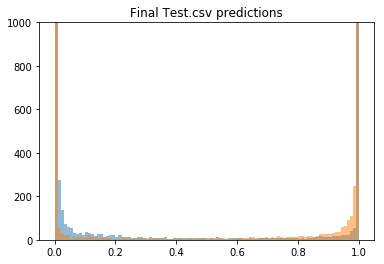

In [8]:
idx_t0 = train['target']== 0
idx_t1 = train['target']== 1
import matplotlib.pyplot as plt
plt.hist(oof3[idx_t0],bins=100,alpha=0.5)
plt.hist(oof3[idx_t1],bins=100,alpha=0.5)
plt.title('Final Test.csv predictions')
plt.ylim([0,1000])
plt.show()

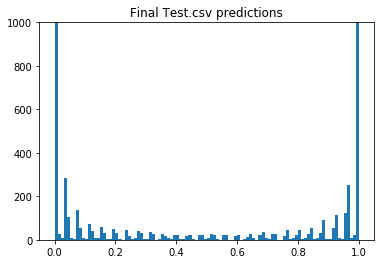

In [9]:
#submission
sub = pd.read_csv('../input/sample_submission.csv')
sub['target'] = preds
sub.to_csv('submission_GMM.csv', index=False)
import matplotlib.pyplot as plt
plt.hist(preds,bins=100)
plt.title('Final Test.csv predictions')
plt.ylim([0,1000])
plt.show()

In [10]:
print('pred 0', sum(preds<0.001))
print('pred 1', sum(preds>0.999))

pred 0 63988
pred 1 64170
